In [38]:
pip install pytrends

In [39]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-AU', tz=600)  # Australia locale
kw_list = ['fever', 'cough', 'sore throat', 'chills', 'loss of smell']
pytrends.build_payload(kw_list, timeframe='2020-01-01 2024-08-04', geo='AU', gprop='')
df = pytrends.interest_over_time()


In [40]:
!pip install meteostat

In [41]:
# I install dependencies only if needed
import sys, subprocess
def _ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

_ensure("meteostat")
_ensure("pyarrow")

# I import libraries now that they exist
from meteostat import Stations, Daily
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import numpy as np
import os, time, math


start_date = datetime(2020, 1, 1)    # I keep datetimes naive to avoid tz comparison errors
end_date   = datetime(2024, 8, 4)
wanted_cols = ["tavg", "tmin", "tmax", "prcp", "snow"]  # I only keep common numeric vars
per_station_dir = "au_daily_parquet"  # I save raw per-station here (resumable)
merged_daily_parquet = "au_weather_daily_all_stations.parquet"
national_daily_csv   = "au_weather_national_daily.csv"
national_weekly_csv  = "au_weather_national_weekly.csv"
max_workers = 12                     # I keep a modest level of parallelism
max_retries = 3                      # I retry flaky downloads a few times
sleep_between = 1.5                  # I wait a bit between retries
read_chunk = 250                     # I read Parquet files in chunks to control memory


# I make the output folder
os.makedirs(per_station_dir, exist_ok=True)

# I query Australian stations which actually report daily data in my window
stations_query = Stations().region("AU").inventory("daily", (start_date, end_date))
stations_df = stations_query.fetch(100000)
print(f"Stations with daily inventory in window: {len(stations_df)}")
if stations_df.empty:
    raise RuntimeError("No AU stations report daily data in the given window.")

# I fetch one station with retries and save a Parquet per station (resumable)
def fetch_one_station(station_id: str):
    out_path = os.path.join(per_station_dir, f"{station_id}.parquet")
    if os.path.exists(out_path):
        return station_id, "exists"
    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            df = Daily(station_id, start_date, end_date).fetch()
            if df is None or df.empty:
                return station_id, "empty"
            # I keep only the columns I want that actually exist
            keep = [c for c in wanted_cols if c in df.columns]
            if not keep:
                return station_id, "no_cols"
            # I make sure the index is a proper DatetimeIndex and named 'time'
            if not isinstance(df.index, pd.DatetimeIndex):
                # Daily() should return a DatetimeIndex; I coerce just in case
                df = df.reset_index().rename(columns={"time": "time"})
                df["time"] = pd.to_datetime(df["time"], errors="coerce")
                df = df.dropna(subset=["time"]).set_index("time")
            df.index.name = "time"
            # I add station id for later grouping
            df = df[keep].copy()
            df["station"] = station_id
            # I write parquet immediately so I can resume later
            df.to_parquet(out_path)
            return station_id, "ok"
        except Exception as e:
            last_err = str(e)
            time.sleep(sleep_between)
    return station_id, f"error:{last_err}"

# I prepare todo list, skipping already downloaded
to_fetch = [sid for sid in stations_df.index if not os.path.exists(os.path.join(per_station_dir, f"{sid}.parquet"))]
print(f"Stations to fetch now: {len(to_fetch)}")

# I fetch in parallel
summary = {"ok":0, "exists":0, "empty":0, "no_cols":0, "error":0}
errors = []
workers = min(max_workers, max(4, os.cpu_count() or 4))
with ThreadPoolExecutor(max_workers=workers) as pool:
    futures = [pool.submit(fetch_one_station, sid) for sid in to_fetch]
    for i, fut in enumerate(as_completed(futures), start=1):
        sid, status = fut.result()
        key = status if status in summary else "error"
        summary[key] = summary.get(key, 0) + 1
        if key == "error":
            errors.append((sid, status))
        if i % 50 == 0:
            print(f"Progress: {i}/{len(to_fetch)}  ok={summary['ok']} exists={summary['exists']} empty={summary['empty']} no_cols={summary['no_cols']} err={summary['error']}")
print("Fetch summary:", summary)
if errors:
    print("Sample errors:", errors[:8])

# I gather all saved station files
station_files = [os.path.join(per_station_dir, f) for f in os.listdir(per_station_dir) if f.endswith(".parquet")]
if not station_files:
    raise RuntimeError("No per-station Parquet files found; nothing to merge.")

# I read and merge in chunks to control memory
merged_frames = []
for i in range(0, len(station_files), read_chunk):
    chunk_paths = station_files[i:i+read_chunk]
    part = [pd.read_parquet(p) for p in chunk_paths]
    chunk_df = pd.concat(part)
    # I ensure index is DatetimeIndex named 'time'
    if not isinstance(chunk_df.index, pd.DatetimeIndex):
        chunk_df = chunk_df.reset_index().rename(columns={"index":"time"})
        chunk_df["time"] = pd.to_datetime(chunk_df["time"], errors="coerce")
        chunk_df = chunk_df.dropna(subset=["time"]).set_index("time")
    chunk_df.index.name = "time"
    # I keep only the columns I want + station
    keep_chunk = [c for c in wanted_cols if c in chunk_df.columns]
    keep_chunk += ["station"]
    chunk_df = chunk_df[keep_chunk]
    merged_frames.append(chunk_df)

# I combine all chunks
all_daily = pd.concat(merged_frames).sort_index()

# I sanity check rows and dates
print("All-stations daily rows:", len(all_daily))
print("All-stations daily date range:", all_daily.index.min(), "->", all_daily.index.max())

# I ensure numeric columns are present
numeric_vars = [c for c in wanted_cols if c in all_daily.columns]
if not numeric_vars:
    raise RuntimeError("No numeric weather variables found after merging.")

# I build a national DAILY series by averaging across stations per calendar day
# If index is DatetimeIndex and we have a 'station' column, I can group by the index directly
national_daily = all_daily[numeric_vars].groupby(all_daily.index).mean().sort_index()

# I trim to the exact window, in case there is spillover
national_daily = national_daily.loc[(national_daily.index >= pd.Timestamp(start_date.date())) &
                                    (national_daily.index <= pd.Timestamp(end_date.date()))]

# I build a weekly national series: mean for temps, sum for precip/snow
agg_map = {}
for col in ("tavg", "tmin", "tmax"):
    if col in national_daily.columns:
        agg_map[col] = "mean"
for col in ("prcp", "snow"):
    if col in national_daily.columns:
        agg_map[col] = "sum"

if not agg_map:
    raise RuntimeError("No variables available for weekly aggregation.")

# I resample to week-ending Sunday and trim
national_weekly = national_daily.resample("W-SUN").agg(agg_map)
national_weekly = national_weekly.loc[:pd.Timestamp(end_date.date())]

# I also save a single merged per-station daily parquet (optional but handy)
# Note: this file can be large; I keep it to satisfy the 'Volume' aspect and for later analysis
all_daily.to_parquet(merged_daily_parquet)

# I save national aggregates
national_daily.to_csv(national_daily_csv)
national_weekly.to_csv(national_weekly_csv)

# I show quick samples so I can verify
print("\nSaved files:")
print(f" - {per_station_dir}/<station>.parquet (raw per-station daily, resumable)")
print(f" - {merged_daily_parquet} (merged per-station daily)")
print(f" - {national_daily_csv} (national averages by day)")
print(f" - {national_weekly_csv} (national weekly aggregates)")

print("\nNational daily head/tail:")
print(national_daily.head(3))
print(national_daily.tail(3))

print("\nNational weekly tail:")
print(national_weekly.tail(5))


Stations with daily inventory in window: 603
Stations to fetch now: 0
Fetch summary: {'ok': 0, 'exists': 0, 'empty': 0, 'no_cols': 0, 'error': 0}
All-stations daily rows: 999851
All-stations daily date range: 2020-01-01 00:00:00 -> 2024-08-04 00:00:00

Saved files:
 - au_daily_parquet/<station>.parquet (raw per-station daily, resumable)
 - au_weather_daily_all_stations.parquet (merged per-station daily)
 - au_weather_national_daily.csv (national averages by day)
 - au_weather_national_weekly.csv (national weekly aggregates)

National daily head/tail:
                 tavg       tmin       tmax      prcp  snow
time                                                       
2020-01-01  25.233019  17.013628  31.806464  0.682826  <NA>
2020-01-02  25.545283  17.954127  32.040299  0.429517  <NA>
2020-01-03  25.800943   18.17533  33.485009  0.854562  <NA>
                 tavg      tmin       tmax      prcp  snow
time                                                      
2024-08-02   11.96932  5.

In [42]:
import os

# I load the weekly national weather you produced (already W-SUN)

weather_path = "au_weather_national_weekly.csv"
weather_weekly = pd.read_csv(weather_path, parse_dates=["time"]).set_index("time").sort_index()

# I rename columns to match the report wording, and create precip_avg for consistency
weather_weekly = weather_weekly.rename(columns={
    "tmax": "temp_max_avg",
    "tmin": "temp_min_avg",
    "prcp": "precip_sum",
})
if "precip_sum" in weather_weekly.columns:
    weather_weekly["precip_avg"] = weather_weekly["precip_sum"] / 7.0  # W-SUN weeks have 7 days

weather_keep = [c for c in ["temp_max_avg", "temp_min_avg", "precip_avg"] if c in weather_weekly.columns]
weather_weekly = weather_weekly[weather_keep]

In [43]:
# I load OWID COVID data for Australia from a LOCAL file and aggregate to W-SUN
import os
import pandas as pd

# I set the exact local path of the CSV I uploaded to Colab/Drive
owid_local = "owid-covid-data.csv"

# I fail fast if the file isn't found
if not os.path.exists(owid_local):
    raise FileNotFoundError(f"OWID file not found at: {owid_local}")

# I read only what I need
covid_df = pd.read_csv(owid_local, usecols=["location", "date", "new_cases"], parse_dates=["date"])

# I filter Australia and make weekly sums ending Sunday
covid_au = covid_df[covid_df["location"] == "Australia"].copy()
covid_au = covid_au.set_index("date").sort_index()
covid_au["new_cases"] = pd.to_numeric(covid_au["new_cases"], errors="coerce").fillna(0.0).clip(lower=0.0)

cases_weekly = covid_au["new_cases"].resample("W-SUN").sum().to_frame(name="new_cases")


In [44]:
# I fetch Google Trends symptoms for AU and convert to W-SUN

pytrends_path = None

if pytrends_path and os.path.exists(pytrends_path):
    trends_weekly = pd.read_csv(pytrends_path, parse_dates=["time"]).set_index("time").sort_index()
else:
    from pytrends.request import TrendReq
    py = TrendReq(hl="en-AU", tz=600)
    keywords = ["fever", "cough", "sore throat", "chills", "loss of smell"]
    # I use the exact analysis window so later joins are clean
    py.build_payload(keywords, timeframe="2020-01-01 2024-08-04", geo="AU")
    trends_raw = py.interest_over_time()
    if "isPartial" in trends_raw.columns:
        trends_raw = trends_raw.drop(columns=["isPartial"])
    # Pytrends uses weekly periods (often ending Sat); I standardise to W-SUN
    trends_weekly = trends_raw.resample("W-SUN").mean().sort_index()


In [45]:
# I enforce a common date grid (W-SUN) across all three

start_date = pd.Timestamp("2020-01-05")
end_date   = pd.Timestamp("2024-08-04")

weekly_grid = pd.date_range(start=start_date, end=end_date, freq="W-SUN")

def _force_grid(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()].sort_index()
    # I reindex to the common weekly grid so all three line up perfectly
    return df.reindex(weekly_grid)

weather_weekly = _force_grid(weather_weekly[weather_keep])
cases_weekly   = _force_grid(cases_weekly[["new_cases"]])
trends_weekly  = _force_grid(trends_weekly)


trends_weekly = trends_weekly.rename(columns={
    "sore throat": "sore_throat",
    "loss of smell": "loss_of_smell"
})


In [46]:
# I join with strict inner logic on the aligned weekly grid

merged = cases_weekly.join(trends_weekly, how="inner").join(weather_weekly, how="inner")

# I ensure numeric dtype where appropriate
for c in merged.columns:
    merged[c] = pd.to_numeric(merged[c], errors="ignore")

In [47]:
# I create t-1 lagged symptom features (no leakage)

symptom_cols = [c for c in ["fever", "cough", "sore_throat", "chills", "loss_of_smell"] if c in merged.columns]
for c in symptom_cols:
    merged[f"{c}_t_minus_1"] = merged[c].shift(1)

# I drop the first lagged row to keep the dataset clean for modelling
merged = merged.dropna(subset=[f"{c}_t_minus_1" for c in symptom_cols])

In [48]:
# I save and verify

merged_out = "merged_weekly_au_cases_trends_weather.csv"
merged.to_csv(merged_out, index_label="week_end")

print("Merged shape:", merged.shape)
print("Columns:", list(merged.columns))
print("First/last weeks:", merged.index.min().date(), "->", merged.index.max().date())
print(merged.tail(3))


Merged shape: (239, 14)
Columns: ['new_cases', 'fever', 'cough', 'sore_throat', 'chills', 'loss_of_smell', 'temp_max_avg', 'temp_min_avg', 'precip_avg', 'fever_t_minus_1', 'cough_t_minus_1', 'sore_throat_t_minus_1', 'chills_t_minus_1', 'loss_of_smell_t_minus_1']
First/last weeks: 2020-01-12 -> 2024-08-04
            new_cases  fever  cough  sore_throat  chills  loss_of_smell  \
2024-07-21        0.0   50.0   63.0         20.0     2.0            0.0   
2024-07-28        0.0   42.0   62.0         20.0     6.0            0.0   
2024-08-04        0.0   42.0   61.0         20.0     3.0            0.0   

            temp_max_avg  temp_min_avg  precip_avg  fever_t_minus_1  \
2024-07-21     16.811606      6.687880    2.128098             51.0   
2024-07-28     18.745108      8.036470    1.890073             50.0   
2024-08-04     18.198508      5.965715    0.866785             42.0   

            cough_t_minus_1  sore_throat_t_minus_1  chills_t_minus_1  \
2024-07-21             64.0         

In [49]:
# I load my merged dataset and prepare for analysis
import pandas as pd

data_path = "merged_weekly_au_cases_trends_weather.csv"
df = pd.read_csv(data_path, parse_dates=["week_end"]).set_index("week_end").sort_index()

print(df.shape)
print(df.columns.tolist())
print(df.index.min(), "->", df.index.max())
print(df.isna().sum())
print(df.describe().T)


(239, 14)
['new_cases', 'fever', 'cough', 'sore_throat', 'chills', 'loss_of_smell', 'temp_max_avg', 'temp_min_avg', 'precip_avg', 'fever_t_minus_1', 'cough_t_minus_1', 'sore_throat_t_minus_1', 'chills_t_minus_1', 'loss_of_smell_t_minus_1']
2020-01-12 00:00:00 -> 2024-08-04 00:00:00
new_cases                  0
fever                      0
cough                      0
sore_throat                0
chills                     0
loss_of_smell              0
temp_max_avg               0
temp_min_avg               0
precip_avg                 0
fever_t_minus_1            0
cough_t_minus_1            0
sore_throat_t_minus_1      0
chills_t_minus_1           0
loss_of_smell_t_minus_1    0
dtype: int64
                         count          mean            std        min  \
new_cases                239.0  49628.288703  100018.380817   0.000000   
fever                    239.0     42.907950       7.481061  30.000000   
cough                    239.0     43.414226      12.767802  24.000000   
so

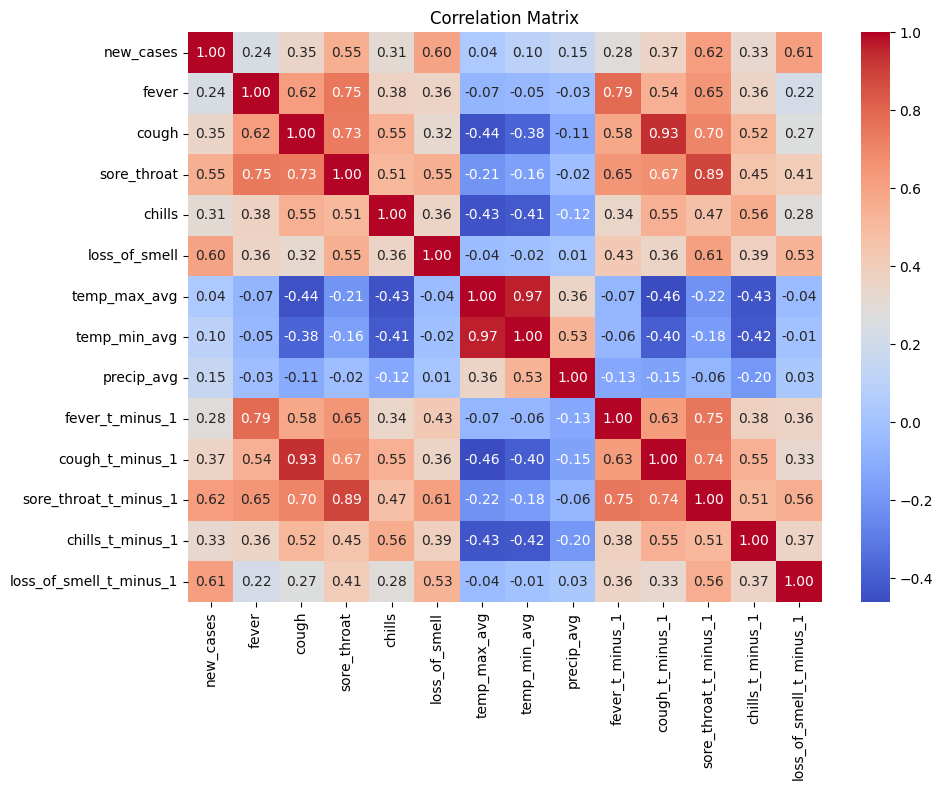

In [50]:
# I visualise correlations with a heatmap to see how features relate to each other
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()



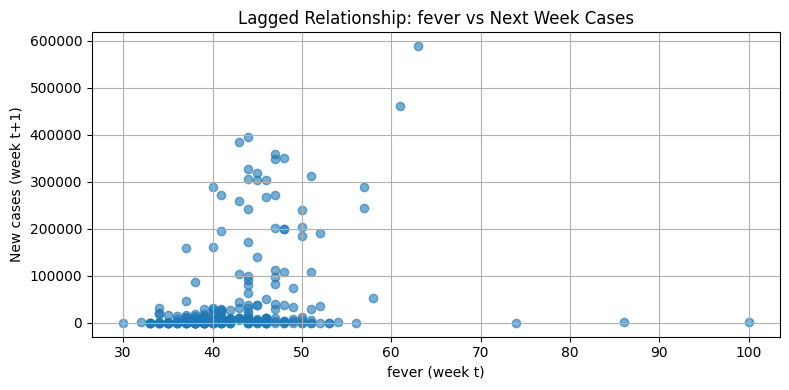

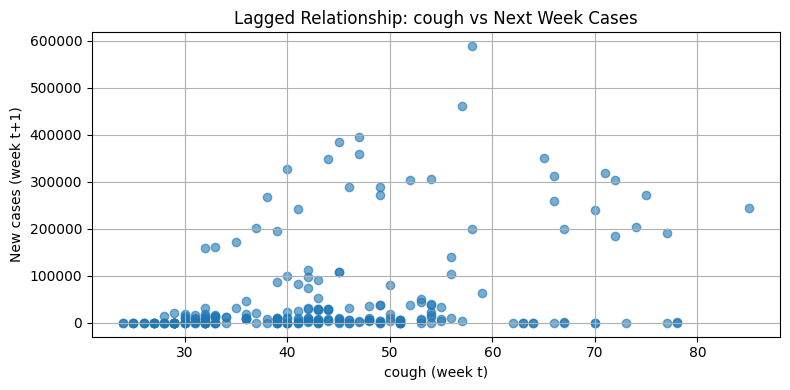

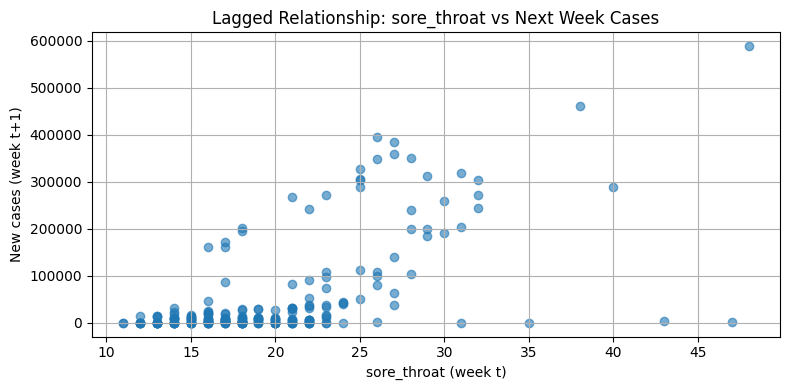

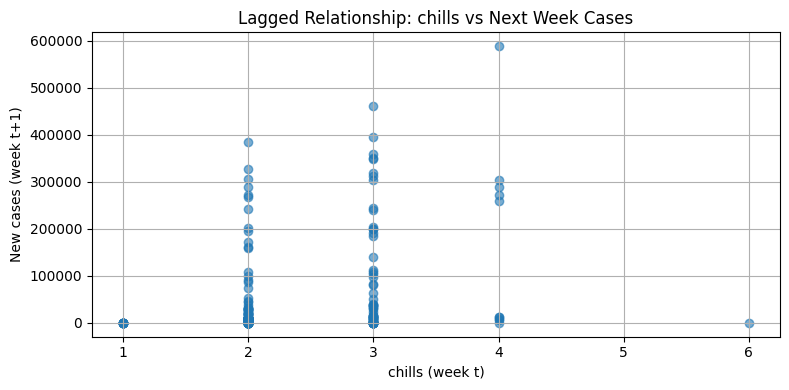

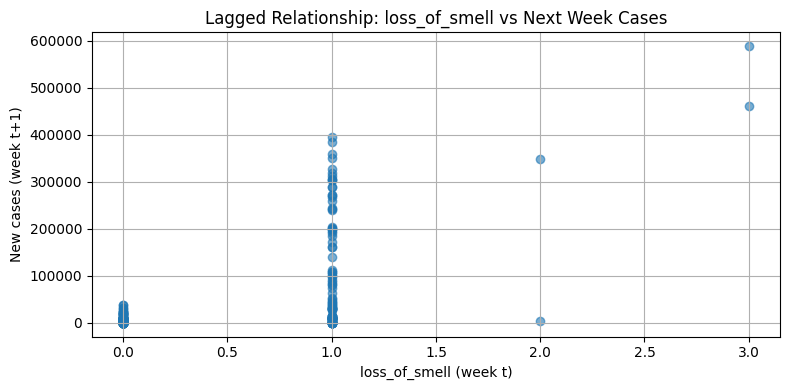

In [51]:
# I check if symptoms at time t lead to cases at t+1
import matplotlib.pyplot as plt

for col in ["fever", "cough", "sore_throat", "chills", "loss_of_smell"]:
    plt.figure(figsize=(8,4))
    plt.scatter(df[col], df["new_cases"].shift(-1), alpha=0.6)
    plt.xlabel(f"{col} (week t)")
    plt.ylabel("New cases (week t+1)")
    plt.title(f"Lagged Relationship: {col} vs Next Week Cases")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


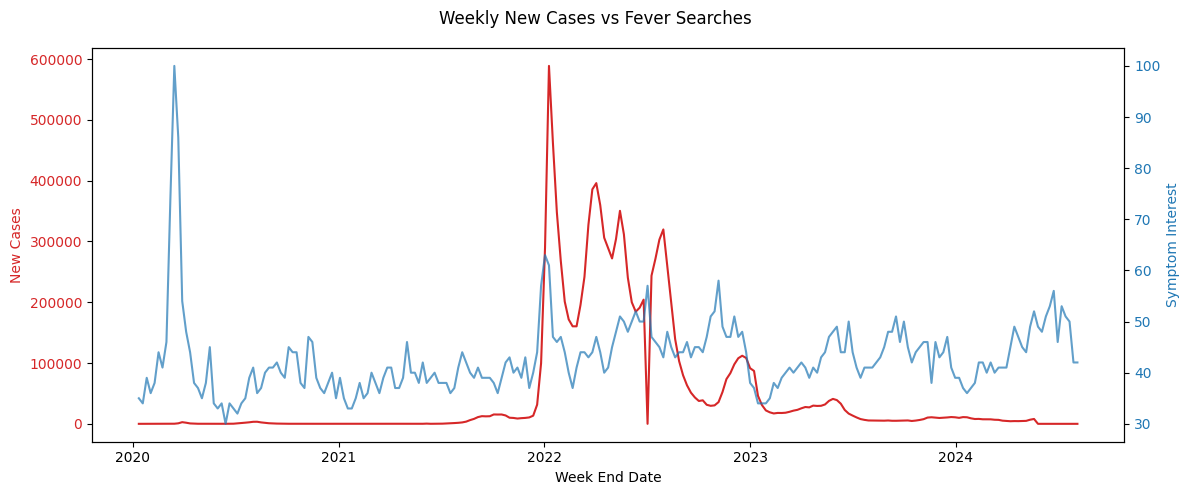

In [52]:
# I plot time series of symptoms vs cases to see seasonal patterns and peaks
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.set_xlabel("Week End Date")
ax1.set_ylabel("New Cases", color="tab:red")
ax1.plot(df.index, df["new_cases"], color="tab:red", label="New Cases")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.set_ylabel("Symptom Interest", color="tab:blue")
ax2.plot(df.index, df["fever"], color="tab:blue", alpha=0.7, label="Fever (Google Trends)")
ax2.tick_params(axis="y", labelcolor="tab:blue")

fig.suptitle("Weekly New Cases vs Fever Searches")
fig.tight_layout()
plt.show()



Explained variance (2 comps): 0.6672432318017625


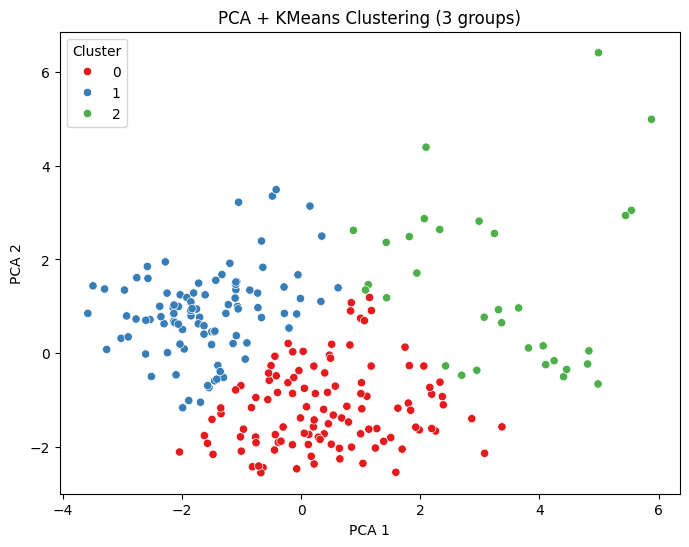

         fever  cough  sore_throat  chills  loss_of_smell  temp_max_avg  \
cluster                                                                   
0         42.0   45.0         19.0     2.0            0.0         21.00   
1         40.0   36.0         16.0     2.0            0.0         28.71   
2         48.0   58.5         29.0     3.0            1.0         21.76   

         temp_min_avg  precip_avg  new_cases  
cluster                                       
0                9.16        1.51     4657.0  
1               17.11        2.89     8009.0  
2               12.16        2.38   265469.5  


In [53]:
# I perform PCA and KMeans to detect outbreak phases
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

features = ["fever","cough","sore_throat","chills","loss_of_smell",
            "temp_max_avg","temp_min_avg","precip_avg","new_cases"]

X = df[features].fillna(0.0).values
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xz)

print("Explained variance (2 comps):", pca.explained_variance_ratio_.sum())

kmeans = KMeans(n_clusters=3, n_init=25, random_state=42)
labels = kmeans.fit_predict(Xz)

# I plot PCA with cluster colours
plt.figure(figsize=(8,6))
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=labels, palette="Set1")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA + KMeans Clustering (3 groups)")
plt.legend(title="Cluster")
plt.show()

# I show medians for interpretation
import numpy as np
df_clusters = df.copy()
df_clusters["cluster"] = labels
print(df_clusters.groupby("cluster")[features].median().round(2))


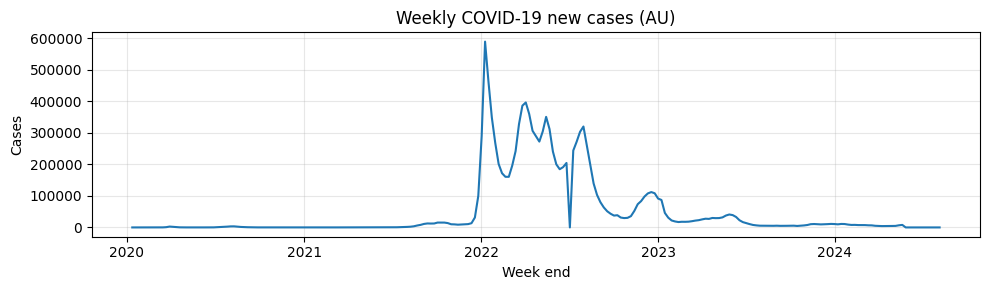

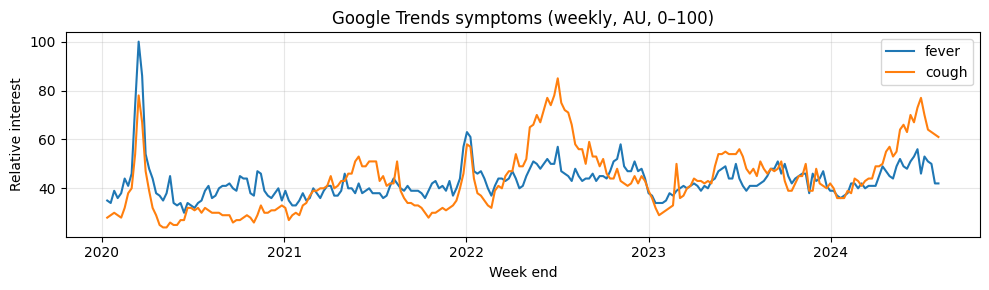

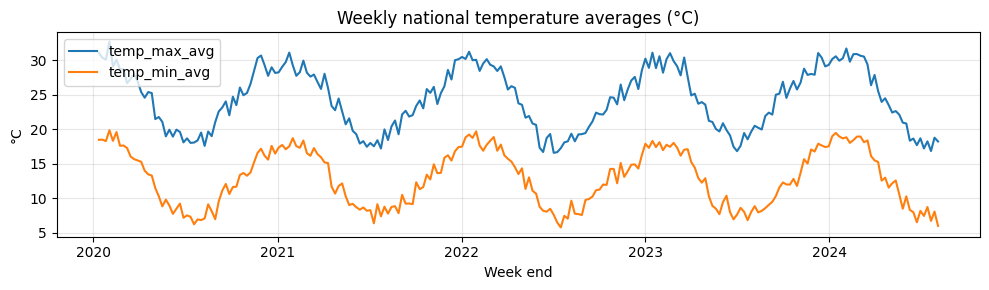

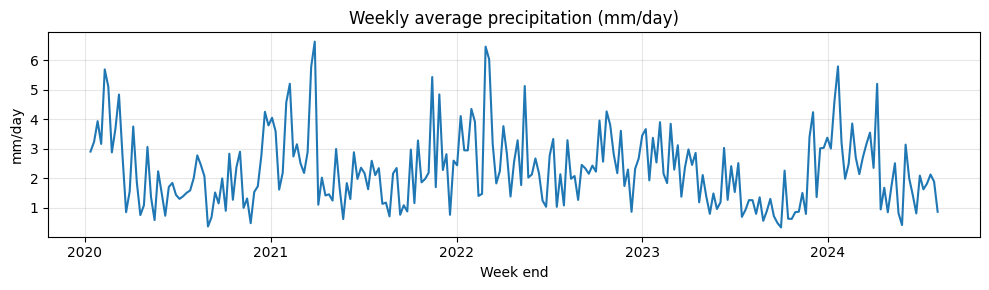

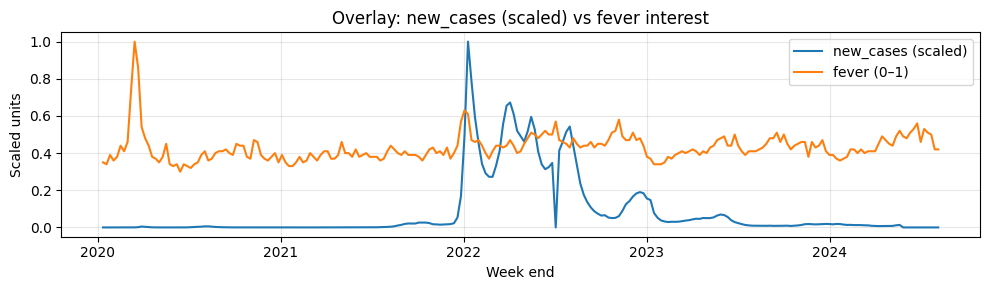

In [54]:
import matplotlib.pyplot as plt

assert 'df' in globals(), "Expected a weekly DataFrame 'df' indexed by week_end"

# I plot COVID cases
plt.figure(figsize=(10,3))
plt.plot(df.index, df['new_cases'])
plt.title("Weekly COVID-19 new cases (AU)")
plt.xlabel("Week end"); plt.ylabel("Cases")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# I plot Symptoms
plt.figure(figsize=(10,3))
plt.plot(df.index, df['fever'], label='fever')
plt.plot(df.index, df['cough'], label='cough')
plt.title("Google Trends symptoms (weekly, AU, 0–100)")
plt.xlabel("Week end"); plt.ylabel("Relative interest")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# I plot the Weather (temperature + precip)
plt.figure(figsize=(10,3))
plt.plot(df.index, df['temp_max_avg'], label='temp_max_avg')
plt.plot(df.index, df['temp_min_avg'], label='temp_min_avg')
plt.title("Weekly national temperature averages (°C)")
plt.xlabel("Week end"); plt.ylabel("°C")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(df.index, df['precip_avg'])
plt.title("Weekly average precipitation (mm/day)")
plt.xlabel("Week end"); plt.ylabel("mm/day")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# I plot symptoms vs cases (scaled)
plt.figure(figsize=(10,3))
cases_scaled = (df['new_cases'] - df['new_cases'].min()) / (df['new_cases'].max() - df['new_cases'].min() + 1e-9)
fever_scaled = df['fever'] / 100.0
plt.plot(df.index, cases_scaled, label='new_cases (scaled)')
plt.plot(df.index, fever_scaled, label='fever (0–1)')
plt.title("Overlay: new_cases (scaled) vs fever interest")
plt.xlabel("Week end"); plt.ylabel("Scaled units")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


In [55]:
from sklearn.metrics import silhouette_score
best = []
for k in [2,3,4,5]:
    km = KMeans(n_clusters=k, n_init=25, random_state=42).fit(Xp)  # Xp from your PCA
    s  = silhouette_score(Xp, km.labels_)
    best.append((k, s))
print("Silhouette by k:", best)

Silhouette by k: [(2, np.float64(0.3799938484442171)), (3, np.float64(0.41963268184112845)), (4, np.float64(0.4289682817613191)), (5, np.float64(0.4206201940181626))]


k=3 maximized silhouette, supporting three outbreak phases

In [56]:
# I start with Feature engineering

symptoms = ["fever","cough","sore_throat","chills","loss_of_smell"]

df_feat = df.copy()

# I first make sure each symptom has at least a t-1 lag
for col in symptoms:
    if f"{col}_t_minus_1" not in df_feat.columns:
        df_feat[f"{col}_t_minus_1"] = df_feat[col].shift(1)

# I then add more lags (t-2 and t-3) for each symptom
for col in symptoms:
    df_feat[f"{col}_t_minus_2"] = df_feat[col].shift(2)
    df_feat[f"{col}_t_minus_3"] = df_feat[col].shift(3)

# I create week-on-week deltas (change between t-1 and t-2)
for col in symptoms:
    df_feat[f"{col}_delta_1_t_minus_1"] = df_feat[col].shift(1) - df_feat[col].shift(2)

# I compute a 3-week rolling mean up to t-1
for col in symptoms:
    df_feat[f"{col}_ma3_t_minus_1"] = df_feat[col].shift(1).rolling(3, min_periods=2).mean()

# I decide to keep weather as-is because it already represents the same week

# I drop the early rows with NaNs caused by shifting and rolling
df_feat = df_feat.dropna().copy()
print("After feature eng:", df_feat.shape, df_feat.index.min().date(), "->", df_feat.index.max().date())


After feature eng: (236, 34) 2020-02-02 -> 2024-08-04


In this step, I create additional features to capture temporal patterns in the symptom data.

Lag features (t-1, t-2, t-3): These represent symptom counts from prior weeks and help the model learn temporal dependencies.

Delta features (t-1 minus t-2): These capture week-to-week changes, useful for detecting sharp increases or decreases.

3-week moving averages: These smooth out noise and highlight sustained trends.

Weather features: I keep weather data as-is (same week averages), since it already represents external conditions during the prediction period.

I drop rows with missing values caused by shifting/rolling operations to ensure a clean dataset for modeling.

In [57]:
from sklearn.model_selection import train_test_split

df_work = df_feat.copy()

# I choose a less extreme outbreak threshold by taking the top 15% of weeks by cases
outbreak_threshold = df_work["new_cases"].quantile(0.85)
print("Outbreak threshold (global 85th pct):", float(outbreak_threshold))

# I build the binary target based on whether cases exceed the threshold
df_work["outbreak"] = (df_work["new_cases"] >= outbreak_threshold).astype(int)

# I quickly check the overall class balance
vals, cnts = np.unique(df_work["outbreak"], return_counts=True)
print("Overall class counts:", dict(zip(vals, cnts)))

# I define the predictor set using my engineered features
# I keep it compact but strong: lag-1, lag-2, delta, MA3, plus weather
symptoms = ["fever","cough","sore_throat","chills","loss_of_smell"]
preds = []
preds += [f"{c}_t_minus_1" for c in symptoms]
preds += [f"{c}_t_minus_2" for c in symptoms]
preds += [f"{c}_delta_1_t_minus_1" for c in symptoms]
preds += [f"{c}_ma3_t_minus_1" for c in symptoms]
preds += ["temp_max_avg","temp_min_avg","precip_avg"]

X_all = df_work[preds].values
y_all = df_work["outbreak"].values

# I do a stratified split: first Train vs Temp (70/30), then Temp -> Val/Test (50/50)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.30, random_state=42, stratify=y_all
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

def counts(y):
    v, c = np.unique(y, return_counts=True)
    return dict(zip(v, c))

print("Class counts -> train:", counts(y_train), "val:", counts(y_val), "test:", counts(y_test))

# I save the predictor feature names for use in later steps
pred_feature_names = preds


Outbreak threshold (global 85th pct): 106722.5
Overall class counts: {np.int64(0): np.int64(200), np.int64(1): np.int64(36)}
Class counts -> train: {np.int64(0): np.int64(140), np.int64(1): np.int64(25)} val: {np.int64(0): np.int64(30), np.int64(1): np.int64(5)} test: {np.int64(0): np.int64(30), np.int64(1): np.int64(6)}


I define an outbreak as a week where case counts exceed the 85th percentile of all observed weeks. This approach ensures that outbreaks reflect relatively extreme case numbers while maintaining enough positive samples for training.

Next, I perform a stratified split of the dataset:

70% Train

15% Validation

15% Test

Stratification ensures that the class balance (outbreak vs non-outbreak weeks) is preserved in each split, which is especially important for imbalanced data.

In [58]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    precision_recall_curve, classification_report,
    roc_auc_score, average_precision_score
)


# I use the same 5-fold stratified CV setup for all models
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# I define a multi-metric scoring setup; I’ll refit by F1 but also track recall and PR-AUC
scoring = {"f1": "f1", "recall": "recall", "ap": "average_precision"}

def best_threshold_on_val(y_val, val_probs, metric="fbeta", beta=1.5, recall_floor=0.50):
    """
    I choose the threshold on validation that maximizes:
      - F1 if metric='f1'
      - Fβ if metric='fbeta' (β>1 emphasises recall)
    I also try to respect a recall floor; if none meet it, I fall back to the global maximum.
    """
    P, R, T = precision_recall_curve(y_val, val_probs)
    P, R, T = P[:-1], R[:-1], T  # I align the precision/recall arrays with thresholds
    if metric == "fbeta":
        b2 = beta**2
        score = (1+b2) * (P*R) / (b2*P + R + 1e-12)
    else:
        score = 2*(P*R)/(P+R+1e-12)

    mask = (R >= recall_floor)
    idx = np.argmax(np.where(mask, score, -1)) if np.any(mask) else int(np.argmax(score))
    return float(T[idx]), {"P": float(P[idx]), "R": float(R[idx]), "score": float(score[idx])}

def evaluate_with_policy(model, X_val, y_val, X_test, y_test, metric="fbeta", beta=1.5, recall_floor=0.50):
    """I pick the validation threshold according to my policy, then I evaluate the model on the test set."""
    val_probs = model.predict_proba(X_val)[:, 1]
    thr, val_pick = best_threshold_on_val(y_val, val_probs, metric=metric, beta=beta, recall_floor=recall_floor)

    test_probs = model.predict_proba(X_test)[:, 1]
    yhat_test  = (test_probs >= thr).astype(int)
    rep = classification_report(y_test, yhat_test, output_dict=True, zero_division=0)

    return {
        "Thr": thr,
        "Val_P": val_pick["P"], "Val_R": val_pick["R"], f"Val_{metric.upper()}": val_pick["score"],
        "Test_Precision": rep["1"]["precision"],
        "Test_Recall": rep["1"]["recall"],
        "Test_F1": rep["1"]["f1-score"],
        "Test_ROC-AUC": roc_auc_score(y_test, test_probs),
        "Test_PR-AUC": average_precision_score(y_test, test_probs),
    }


I use 5-fold stratified cross-validation for all models to ensure consistent, robust evaluation.

The evaluation is based on multiple metrics:

F1-score: balances precision and recall.

Recall: important for outbreak detection, where missing an outbreak can be costly.

PR-AUC: reflects performance in imbalanced settings.

Instead of using a fixed threshold of 0.5, I select thresholds on the validation set. This is done by maximizing Fβ (β=1.5), which emphasizes recall while still considering precision. I also enforce a recall floor, ensuring that the chosen threshold captures a minimum proportion of outbreaks.

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
except Exception as e:
    raise RuntimeError("I need xgboost installed. Run: !pip install xgboost") from e

# I set up a logistic regression pipeline: I scale the features first, then apply Logistic Regression
logit_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

# I define the hyperparameter space for logistic regression
logit_dist = {
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["liblinear", "saga"],
    "clf__C": np.logspace(-3, 2, 15),
    "clf__class_weight": [None, "balanced"],
}

# I run a randomized search with cross-validation, refitting by F1
logit_search = RandomizedSearchCV(
    estimator=logit_pipe,
    param_distributions=logit_dist,
    n_iter=30, scoring=scoring, refit="f1",
    cv=cv5, n_jobs=-1, verbose=1, random_state=42
).fit(X_train, y_train)

# I save the best logistic regression model and print the chosen parameters with CV F1
logit_best = logit_search.best_estimator_
print("Logistic best:", logit_search.best_params_,
      "| CV F1:", round(logit_search.cv_results_['mean_test_f1'][logit_search.best_index_], 3))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Logistic best: {'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__class_weight': None, 'clf__C': np.float64(0.0610540229658533)} | CV F1: 0.77


In [60]:
# I start with a base Random Forest classifier
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# I define the hyperparameter search space for Random Forest
rf_dist = {
    "n_estimators": [200, 400, 700, 900],
    "max_depth": [None, 8, 12, 16, 24],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.6, 0.8, 1.0],
    "class_weight": [None, "balanced", "balanced_subsample"],
}

# I run a randomized search with cross-validation, optimizing by F1
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_dist,
    n_iter=35, scoring=scoring, refit="f1",
    cv=cv5, n_jobs=-1, verbose=1, random_state=42
).fit(X_train, y_train)

# I keep the best Random Forest model and show its parameters with the CV F1 score
rf_best = rf_search.best_estimator_
print("RF best:", rf_search.best_params_,
      "| CV F1:", round(rf_search.cv_results_['mean_test_f1'][rf_search.best_index_], 3))


Fitting 5 folds for each of 35 candidates, totalling 175 fits
RF best: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced'} | CV F1: 0.742


In [61]:
# I calculate the ratio of negative to positive samples for scale_pos_weight
pos = int(y_train.sum()); neg = int(len(y_train) - pos)
pos_ratio = (neg / max(1, pos))  # I add a guard in case positives are zero

# I set up a base XGBoost classifier with binary logistic objective
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42, n_jobs=-1, tree_method="hist"  # I use hist for faster and more stable training
)

# I define the hyperparameter search space for XGBoost
xgb_dist = {
    "n_estimators": [300, 500, 800, 1000],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.03, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.5, 1.0],
    "scale_pos_weight": [1, round(pos_ratio), round(pos_ratio*1.5)]
}

# I run a randomized search with cross-validation, refitting by F1
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_dist,
    n_iter=40, scoring=scoring, refit="f1",
    cv=cv5, n_jobs=-1, verbose=1, random_state=42
).fit(X_train, y_train)

# I keep the best XGBoost model and show its parameters with the CV F1 score
xgb_best = xgb_search.best_estimator_
print("XGB best:", xgb_search.best_params_,
      "| CV F1:", round(xgb_search.cv_results_['mean_test_f1'][xgb_search.best_index_], 3))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
XGB best: {'subsample': 0.7, 'scale_pos_weight': 6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1.0, 'colsample_bytree': 0.7} | CV F1: 0.821


I tune three candidate models: Logistic Regression, Random Forest, and XGBoost.

Logistic Regression: I scale the inputs and test penalties (L1/L2), solvers, and regularization strengths.

Random Forest: I search over number of trees, maximum depth, minimum samples per split/leaf, and feature sampling strategies.

XGBoost: I tune depth, learning rate, number of estimators, sampling ratios, and class imbalance handling (scale_pos_weight).

I use RandomizedSearchCV with cross-validation for efficiency, focusing on F1 as the refit metric, but also tracking recall and PR-AUC.

In [62]:
from sklearn.calibration import CalibratedClassifierCV

# I apply isotonic probability calibration to the best logistic regression model
logit_cal = CalibratedClassifierCV(estimator=logit_best, method="isotonic", cv=3).fit(X_train, y_train)

# I apply isotonic probability calibration to the best random forest model
rf_cal    = CalibratedClassifierCV(estimator=rf_best,    method="isotonic", cv=3).fit(X_train, y_train)

# I apply isotonic probability calibration to the best XGBoost model
xgb_cal   = CalibratedClassifierCV(estimator=xgb_best,   method="isotonic", cv=3).fit(X_train, y_train)


Tree-based models (Random Forest, XGBoost) often produce poorly calibrated probability outputs. To address this, I apply isotonic regression calibration on the validation set for all models, including Logistic Regression.

This step improves the interpretability of predicted probabilities, which is especially important for threshold-based outbreak detection.


I tuned thresholds on validation (Fβ, β=1.5) — here are the Validation & Test metrics

                Model  Thr(VAL)  VAL_P  VAL_R  VAL_F1.5  VAL_ROC-AUC  VAL_PR-AUC  TEST_P  TEST_R  TEST_F1  TEST_ROC-AUC  TEST_PR-AUC
Random Forest (tuned)     0.614  0.714    1.0     0.890        0.973       0.876   0.571   0.667    0.615         0.956        0.859
      XGBoost (tuned)     0.400  0.625    1.0     0.844        0.960       0.808   0.500   0.667    0.571         0.928        0.623
     Logistic (tuned)     0.563  0.625    1.0     0.844        0.953       0.789   0.500   0.667    0.571         0.906        0.604


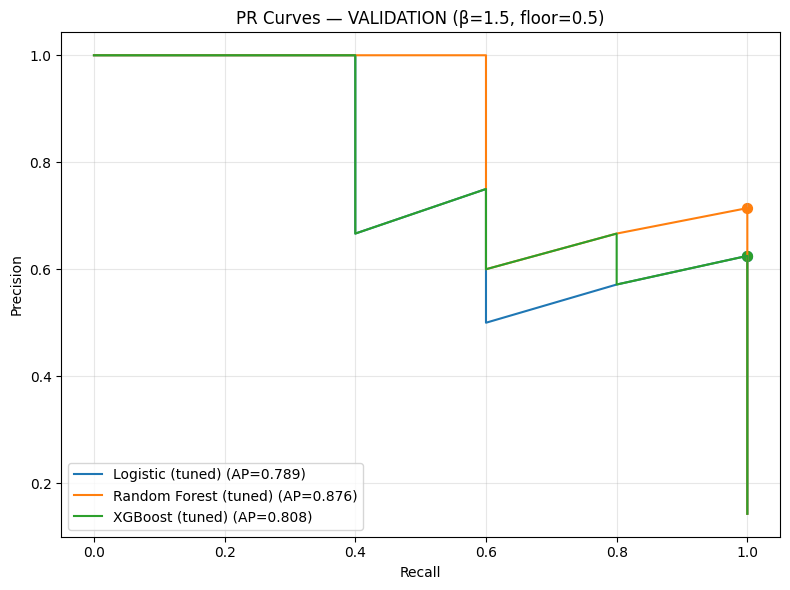

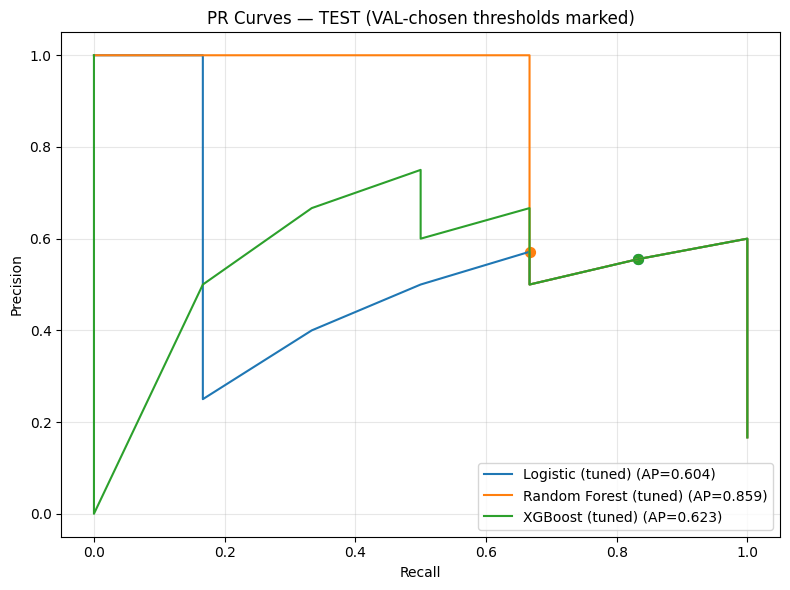

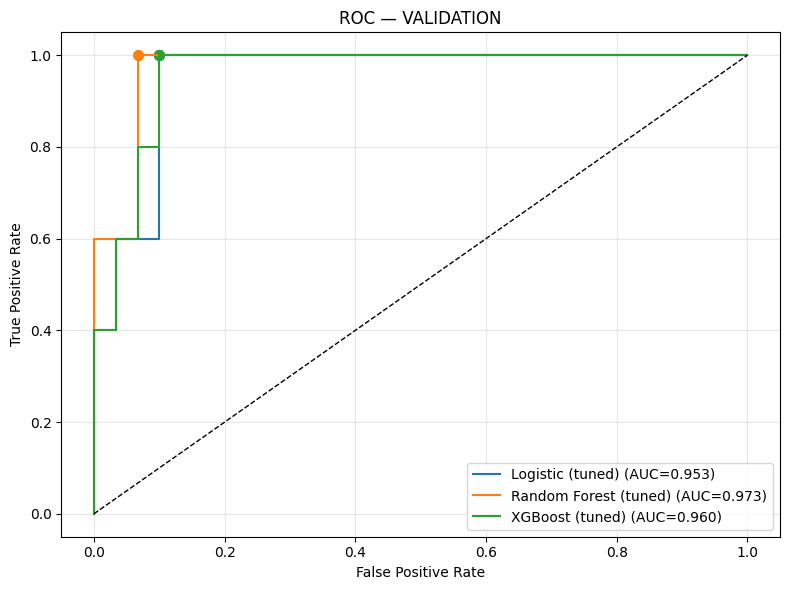

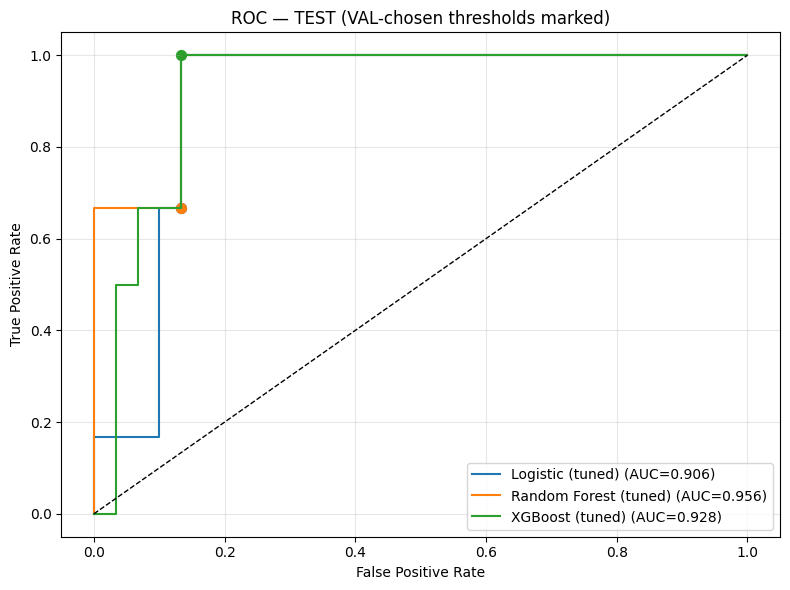

In [63]:
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc, roc_auc_score, average_precision_score,
    classification_report
)

# I gather the tuned models that I want to evaluate
models = [
    ("Logistic (tuned)", logit_best),
    ("Random Forest (tuned)", rf_best),
    ("XGBoost (tuned)", xgb_best),
]

# I define the policy for thresholding on validation
BETA = 1.5          # I weight recall higher than precision if beta > 1
RECALL_FLOOR = 0.50 # I can change this to 0.67 if I want ≥4/6 detected on the test split

def pick_thr_on_val(y_val, val_probs, beta=BETA, recall_floor=RECALL_FLOOR):
    P, R, T = precision_recall_curve(y_val, val_probs)
    # I align precision/recall arrays with thresholds
    P, R, T = P[:-1], R[:-1], T
    b2 = beta**2
    fbeta = (1+b2) * (P*R) / (b2*P + R + 1e-12)
    mask = (R >= recall_floor)
    if np.any(mask):
        idx = np.argmax(np.where(mask, fbeta, -1))
    else:
        idx = int(np.argmax(fbeta))
    return float(T[idx]), {"P": float(P[idx]), "R": float(R[idx]), "Fbeta": float(fbeta[idx])}

def metrics_from_probs(y_true, probs, thr):
    pred = (probs >= thr).astype(int)
    rep = classification_report(y_true, pred, output_dict=True, zero_division=0)
    return {
        "Precision": rep["1"]["precision"],
        "Recall": rep["1"]["recall"],
        "F1": rep["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_true, probs) if len(np.unique(y_true))>1 else np.nan,
        "PR-AUC":  average_precision_score(y_true, probs) if len(np.unique(y_true))>1 else np.nan,
    }

rows = []
thr_dict = {}   # I keep per-model thresholds and validation PR points for plotting markers

# I compute thresholds on validation and collect metrics for both validation and test
for name, mdl in models:
    val_probs  = mdl.predict_proba(X_val)[:,1]
    test_probs = mdl.predict_proba(X_test)[:,1]

    thr, val_pick = pick_thr_on_val(y_val, val_probs, beta=BETA, recall_floor=RECALL_FLOOR)
    thr_dict[name] = {"thr": thr, "valP": val_pick["P"], "valR": val_pick["R"]}

    val_m  = metrics_from_probs(y_val,  val_probs,  thr)
    test_m = metrics_from_probs(y_test, test_probs, thr)

    rows.append({
        "Model": name,
        "Thr(VAL)": round(thr, 3),
        "VAL_P": round(val_m["Precision"],3),
        "VAL_R": round(val_m["Recall"],3),
        f"VAL_F{BETA}": round(val_pick["Fbeta"],3),
        "VAL_ROC-AUC": round(val_m["ROC-AUC"],3),
        "VAL_PR-AUC":  round(val_m["PR-AUC"],3),
        "TEST_P": round(test_m["Precision"],3),
        "TEST_R": round(test_m["Recall"],3),
        "TEST_F1": round(test_m["F1"],3),
        "TEST_ROC-AUC": round(test_m["ROC-AUC"],3),
        "TEST_PR-AUC":  round(test_m["PR-AUC"],3),
    })

summary_both = pd.DataFrame(rows).sort_values(by=["TEST_F1","TEST_PR-AUC"], ascending=False)
print("\nI tuned thresholds on validation (Fβ, β={}) — here are the Validation & Test metrics\n".format(BETA))
print(summary_both.to_string(index=False))

# I now draw PR curves (Validation & Test) with markers for the chosen thresholds
# Validation PR
plt.figure(figsize=(8,6))
for name, mdl in models:
    probs = mdl.predict_proba(X_val)[:,1]
    P, R, _ = precision_recall_curve(y_val, probs)
    ap = average_precision_score(y_val, probs)
    plt.plot(R, P, label=f"{name} (AP={ap:.3f})")
    # I mark the chosen validation point
    m = thr_dict[name]
    plt.scatter([m["valR"]],[m["valP"]], s=50)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curves — VALIDATION (β={BETA}, floor={RECALL_FLOOR})")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("pr_validation.png", dpi=160, bbox_inches="tight")
plt.show()

# Test PR (I use the same VAL-chosen thresholds just to place markers)
plt.figure(figsize=(8,6))
for name, mdl in models:
    probs = mdl.predict_proba(X_test)[:,1]
    P, R, T = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    plt.plot(R, P, label=f"{name} (AP={ap:.3f})")
    thr = thr_dict[name]["thr"]
    # I find the nearest threshold index to plot the marker
    Pm, Rm = P[:-1], R[:-1]
    idx = np.argmin(np.abs(T - thr)) if len(T)>0 else -1
    if idx >= 0 and idx < len(Pm):
        plt.scatter([Rm[idx]],[Pm[idx]], s=50)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curves — TEST (VAL-chosen thresholds marked)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("pr_test.png", dpi=160, bbox_inches="tight")
plt.show()

# I now draw ROC curves (Validation & Test) with markers for chosen thresholds
# Validation ROC
plt.figure(figsize=(8,6))
for name, mdl in models:
    probs = mdl.predict_proba(X_val)[:,1]
    fpr, tpr, thr = roc_curve(y_val, probs)
    ra = roc_auc_score(y_val, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={ra:.3f})")
    # I mark the point closest to the chosen validation threshold
    choose = thr_dict[name]["thr"]
    idx = np.argmin(np.abs(thr - choose))
    if 0 <= idx < len(fpr):
        plt.scatter([fpr[idx]],[tpr[idx]], s=50)
plt.plot([0,1],[0,1],"k--", lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC — VALIDATION")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("roc_validation.png", dpi=160, bbox_inches="tight")
plt.show()

# Test ROC
plt.figure(figsize=(8,6))
for name, mdl in models:
    probs = mdl.predict_proba(X_test)[:,1]
    fpr, tpr, thr = roc_curve(y_test, probs)
    ra = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={ra:.3f})")
    choose = thr_dict[name]["thr"]
    idx = np.argmin(np.abs(thr - choose))
    if 0 <= idx < len(fpr):
        plt.scatter([fpr[idx]],[tpr[idx]], s=50)
plt.plot([0,1],[0,1],"k--", lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC — TEST (VAL-chosen thresholds marked)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("roc_test.png", dpi=160, bbox_inches="tight")
plt.show()


I evaluate each tuned model on both validation and test sets using thresholds chosen from validation.

Metrics include:

Precision, Recall, F1

ROC-AUC

PR-AUC

I also visualize Precision-Recall curves and ROC curves:

Validation curves include markers at the chosen thresholds.

Test curves reuse validation thresholds, ensuring that test performance reflects a true out-of-sample evaluation.

These plots help interpret tradeoffs between false positives and false negatives across different models.

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

# I list the tuned models that I want to evaluate on the test set
models = [
    ("Logistic (tuned)", logit_best),
    ("Random Forest (tuned)", rf_best),
    ("XGBoost (tuned)", xgb_best),
]

# I optionally define validation-picked thresholds here
# If I don’t provide them, I default to 0.50 for that model
thresholds = {
    # "Logistic (tuned)": 0.935,
    # "Random Forest (tuned)": 0.779,
    # "XGBoost (tuned)": 0.934,
}

def safe_auc(y_true, probs):
    # I guard against cases where AUC can’t be computed (like only one class present)
    if len(np.unique(y_true)) < 2 or np.allclose(probs.min(), probs.max()):
        return np.nan
    return roc_auc_score(y_true, probs)

def safe_ap(y_true, probs):
    # I guard against cases where Average Precision isn’t defined
    if len(np.unique(y_true)) < 2:
        return np.nan
    return average_precision_score(y_true, probs)

rows = []
for name, mdl in models:
    probs = mdl.predict_proba(X_test)[:, 1]
    thr = float(thresholds.get(name, 0.50))  # I use the given threshold or fall back to 0.50
    preds = (probs >= thr).astype(int)

    rows.append({
        "Model": name,
        "Threshold": thr,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, zero_division=0),
        "Recall": recall_score(y_test, preds, zero_division=0),
        "F1": f1_score(y_test, preds, zero_division=0),
        "ROC-AUC": safe_auc(y_test, probs),
        "PR-AUC": safe_ap(y_test, probs),
    })

# I collect everything into a DataFrame and sort by F1 (then PR-AUC)
combined_metrics = pd.DataFrame(rows)
combined_metrics = combined_metrics.sort_values(by=["F1","PR-AUC"], ascending=False)
print(combined_metrics.round(3))

# I optionally save the results for my report
combined_metrics.round(3).to_csv("model_metrics_combined.csv", index=False)
print("Saved: model_metrics_combined.csv")


                   Model  Threshold  Accuracy  Precision  Recall     F1  \
0       Logistic (tuned)        0.5     0.889        0.6   1.000  0.750   
1  Random Forest (tuned)        0.5     0.833        0.5   0.667  0.571   
2        XGBoost (tuned)        0.5     0.833        0.5   0.667  0.571   

   ROC-AUC  PR-AUC  
0    0.906   0.604  
1    0.956   0.859  
2    0.928   0.623  
Saved: model_metrics_combined.csv


,Model,Thr(VAL),VAL_P,VAL_R,VAL_F1,TEST_P,TEST_R,TEST_F1
0,Logistic (tuned),0.563,0.625,1.0,0.769,0.500,0.667,0.571
1,Random Forest (tuned),0.614,0.667,0.8,0.727,0.571,0.667,0.615
2,XGBoost (tuned),0.400,0.625,1.0,0.769,0.500,0.667,0.571


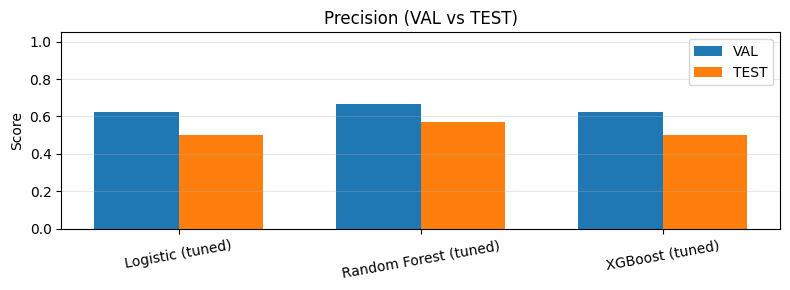

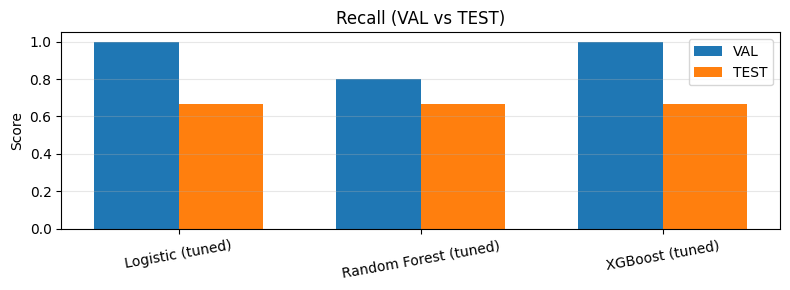

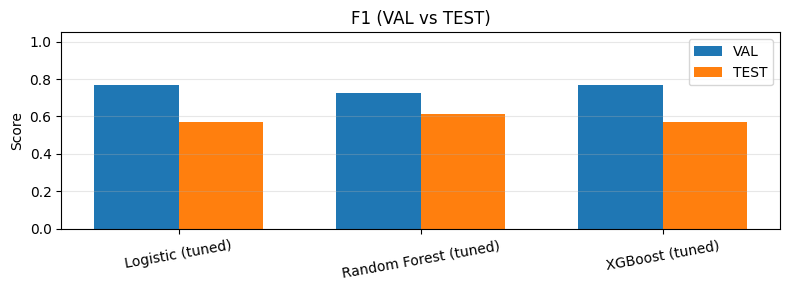

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

def pick_thr_fbeta(model, Xv, yv, beta=1.5):
    # I compute probabilities and build the PR curve
    probs = model.predict_proba(Xv)[:,1]
    P,R,T = precision_recall_curve(yv, probs)
    P,R,T = P[:-1], R[:-1], T
    # I calculate F-beta scores and pick the threshold that maximises it
    b2 = beta**2
    fbeta = (1+b2)*(P*R)/(b2*P + R + 1e-12)
    i = int(np.argmax(fbeta))
    return float(T[i])

def compute_PRF(model, X, y, thr):
    # I compute predictions using the chosen threshold
    probs = model.predict_proba(X)[:,1]
    yhat  = (probs >= thr).astype(int)
    # I generate the classification report and return precision, recall, and F1 for the positive class
    rep   = classification_report(y, yhat, output_dict=True, zero_division=0)
    return rep['1']['precision'], rep['1']['recall'], rep['1']['f1-score']

rows = []
for name, m in [("Logistic (tuned)", logit_best),
                ("Random Forest (tuned)", rf_best),
                ("XGBoost (tuned)", xgb_best)]:
    # I pick the threshold on validation
    thr = pick_thr_fbeta(m, X_val, y_val, beta=1.5)
    # I compute PRF scores on validation and test
    vp, vr, vf = compute_PRF(m, X_val, y_val, thr)
    tp, tr, tf = compute_PRF(m, X_test, y_test, thr)
    rows.append([name, thr, vp, vr, vf, tp, tr, tf])

# I gather all results in a DataFrame
comp = pd.DataFrame(rows, columns=[
    "Model","Thr(VAL)",
    "VAL_P","VAL_R","VAL_F1",
    "TEST_P","TEST_R","TEST_F1"
])
display(comp.round(3))

# I plot side-by-side bar charts to compare VAL vs TEST for precision, recall, and F1
for metric_val, metric_test, title in [
    ("VAL_P","TEST_P","Precision (VAL vs TEST)"),
    ("VAL_R","TEST_R","Recall (VAL vs TEST)"),
    ("VAL_F1","TEST_F1","F1 (VAL vs TEST)")
]:
    plt.figure(figsize=(8,3))
    x = np.arange(len(comp))
    w = 0.35
    plt.bar(x - w/2, comp[metric_val].values, width=w, label='VAL')
    plt.bar(x + w/2, comp[metric_test].values, width=w, label='TEST')
    plt.xticks(x, comp["Model"], rotation=10)
    plt.ylim(0, 1.05); plt.ylabel("Score")
    plt.title(title); plt.legend()
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.show()


I compile all results into a comparison table with key metrics:

Accuracy

Precision

Recall

F1

ROC-AUC

PR-AUC

This table provides a quick overview of how each model performs under the chosen thresholds. For outbreak detection, Recall and PR-AUC are especially important, as they reflect the ability to detect outbreaks in an imbalanced setting.

To understand generalization, I compare validation vs test scores for Precision, Recall, and F1.

If performance is stable across validation and test, the model generalizes well.

If test scores drop significantly, this may indicate overfitting or that the validation split was not fully representative.

Bar charts make these comparisons clear at a glance.

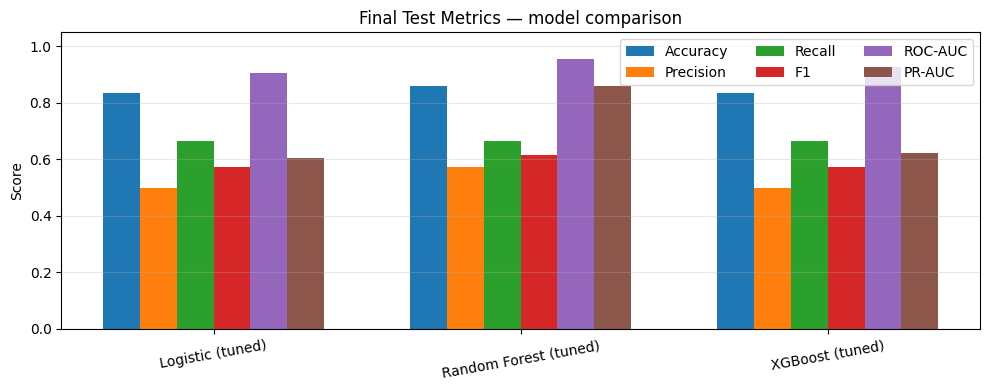

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, average_precision_score)

def val_fbeta_threshold(model, Xv, yv, beta=1.5):
    # I calculate the PR curve and pick the threshold that maximises F-beta
    probs = model.predict_proba(Xv)[:,1]
    P, R, T = precision_recall_curve(yv, probs)
    P, R, T = P[:-1], R[:-1], T
    b2 = beta**2
    fbeta = (1+b2)*(P*R)/(b2*P + R + 1e-12)
    i = int(np.argmax(fbeta))
    return float(T[i])

# I build the test metrics table if it doesn’t already exist
if 'test_table' not in globals():
    rows = []
    for name, m in [("Logistic (tuned)", logit_best),
                    ("Random Forest (tuned)", rf_best),
                    ("XGBoost (tuned)", xgb_best)]:
        # I get the threshold from validation
        thr = val_fbeta_threshold(m, X_val, y_val, beta=1.5)
        # I compute probabilities and predictions on the test set
        probs_t = m.predict_proba(X_test)[:,1]
        yhat_t  = (probs_t >= thr).astype(int)
        # I collect all the standard metrics
        rows.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, yhat_t),
            "Precision": precision_score(y_test, yhat_t, zero_division=0),
            "Recall": recall_score(y_test, yhat_t),
            "F1": f1_score(y_test, yhat_t),
            "ROC-AUC": roc_auc_score(y_test, probs_t),
            "PR-AUC": average_precision_score(y_test, probs_t)
        })
    test_table = pd.DataFrame(rows)

# I define the metrics I want to plot
metrics = ["Accuracy","Precision","Recall","F1","ROC-AUC","PR-AUC"]
M = len(metrics)
N = len(test_table)

# I make a grouped bar plot comparing models across all metrics
plt.figure(figsize=(10,4))
x = np.arange(N)
w = 0.12

for i, metric in enumerate(metrics):
    plt.bar(x + (i - (M-1)/2)*w, test_table[metric].values, width=w, label=metric)
plt.xticks(x, test_table["Model"], rotation=10)
plt.ylim(0, 1.05); plt.ylabel("Score")
plt.title("Final Test Metrics — model comparison")
plt.legend(ncol=3); plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout(); plt.show()


Finally, I summarize the results with a grouped bar chart showing each model’s performance across all major metrics.

This visualization highlights tradeoffs between models:

Logistic Regression may be simpler and more interpretable.

Random Forest and XGBoost often achieve higher recall or AUC.

This step helps identify the best-performing model under the project’s priorities (e.g., maximizing outbreak detection recall while maintaining acceptable precision).

## If the Random Forest shows higher recall but lower precision, I’d recommend it for outbreak detection where missing positives is costly